# Academic test

Importing relevant libraries:

In [33]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

### Parameters to be used in the academic test

In [34]:
T = 1
gamma = 1
alpha_g = 2
beta_g = 1.27 * 10**(-3)
sigma_g = 0.1863
r = 0.02

In [35]:
g_bar = 0.5
g_hat = 2*g_bar
b_hat = 1

## First Numerical Method 

### Parameters to be used 

In [36]:
omega = 2
eps = 10**(-5)

In [37]:
space_steps = 32
time_steps = 40

In [38]:
delta_tau = gamma/time_steps
tau_mesh = [n*delta_tau for n in range(time_steps+1)]

Remember: $\hat{B} \in [0,1]$ and $\hat{G} \in [0,1]$.

In [39]:
delta_B = 1/space_steps
B_mesh = [i*delta_B for i in range(space_steps+1)]

delta_G = 1/space_steps
G_mesh = [j*delta_G for j in range(space_steps+1)]

We must solve the linear system: $C(\hat{G})P_i^{n+1} = b_i^n$ at each time step and for each value of $i=1,2,\dots,N_{\hat{B}}-1$. That is done below.  
But before, we do have an analytical solution for this problem.

## Analytical Solution

In [40]:
def analytical_solution(B_hat, G_hat, tau):
    return np.exp(tau*(B_hat*b_hat)*(G_hat*g_hat - g_bar))

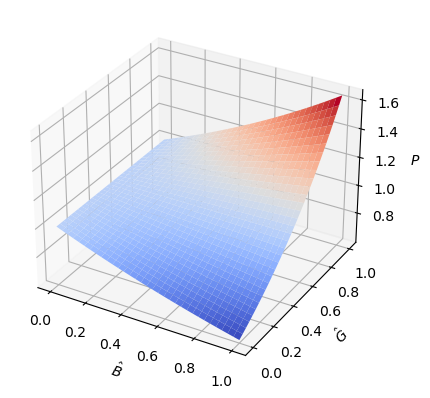

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B_hat, G_hat = np.meshgrid(B_mesh, G_mesh)
Z = analytical_solution(B_hat, G_hat,1)
# Plot the surface.
ax.plot_surface(B_hat, G_hat, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$\hat{B}$')
ax.set_ylabel(r'$\hat{G}$')
ax.set_zlabel(r'$P$')

plt.show()

The previous image depicts the solution of the PDE in the new system of coordinates $\left( \hat{B}, \hat{G} \right)$ at a fixed time $(t=0)$.

In [42]:
def analytical_solution2(B, G_tilde, T = 1, t = 0):
    B_hat = B/b_hat
    G_hat = (G_tilde + g_bar)/g_hat
    return np.exp((T-t)*B_hat*G_hat)

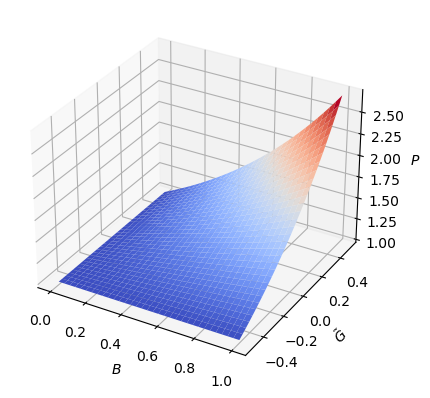

In [43]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B_hat, G_hat = np.meshgrid(B_mesh, G_mesh)
B = B_hat * b_hat
G_tilde = G_hat * g_hat - g_bar
Z = analytical_solution2(B, G_tilde)

# Plot the surface.
ax.plot_surface(B, G_tilde, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$\tilde{G}$')
ax.set_zlabel(r'$P$')

plt.show()

The previous image, however, depicts the solution of the PDE in the original system of coordinates $\left( B, \tilde{G} \right)$ at a fixed time $(t=0)$.

### $C(\hat{G}) $ matrix 

In this academic test there is no seasonality, that is, $f=0$.

In [44]:
def f():
    return 0

We have a tridiagonal matrix with the following entries:

In [45]:
def c1():
    c1_value = 1 + 0.5*r*delta_tau + 0.5* (g_hat**2 * sigma_g**2 * delta_tau)/(delta_G**2)
    return c1_value

def c2(j):
    c2_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) - 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c2_value

def c3(j):
    c3_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) + 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c3_value

We can now construct the tridiagonal $C$ matrix.

In [46]:
C_matrix = [[0 for i in range(space_steps+1)] for j in range(space_steps+1)]
#main diagonal
for i in range(1,space_steps):
    C_matrix[i][i] = c1()
    
#top diagonal
for i in range(1,space_steps-1):
    C_matrix[i][i+1] = c2(i)
    
#bottom diagonal
for i in range(1,space_steps-1):
    C_matrix[i+1][i] = c3(i)
    
C_matrix[0][0] = 1
C_matrix[space_steps][space_steps] = 1

### $\left( b_i^n \right)_j$ vector 

This is a vector to be updated in each time step. First you solve the linear system and get to a array $P$ and then subtitute it on the right-hand side of the equation to get the $b$ vector.  
There are some multiplying factors. To simplify notation in the following steps, I define them here.

In [47]:
def mult_factor1():
    m1_value = (1 - r*delta_tau*0.5) - (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(delta_G**2)
    return m1_value

def mult_factor3():
    m3_value = (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(2 * delta_G**2)
    return m3_value

def mult_factor5():
    m5_value = 0.5 * g_hat * delta_tau * beta_g / (4*delta_G)
    return m5_value


We must also define the non-linear function $m$ to update $\theta$. 

In [48]:
def m(theta, P, omega=2):
    if P + theta/(2*omega) <=0:
        a = -theta - 2*omega*P
        return a
    else:
        b = theta + 2*omega*P + omega**2 - omega * np.sqrt(4*theta + 8*omega*P + omega**2)
        return b

## Solving the linear system and updating values 

In this academic test, we intend to solve $\mathcal{L}_1[P]=h$. The function $h$ is written in terms of the original coordinates $\left( B, \tilde{G} \right)$ and with respect to time $t=T-\tau$:

In [49]:
def h(n,i,j):
    t = [T - tau_mesh[n] for n in range(len(tau_mesh))]
    G_tilde = [G_mesh[i] * g_hat - g_bar for i in range(len(G_mesh))]
    B = [B_mesh[i] * b_hat for i in range(len(G_mesh))]
    #G_hat = [G_mesh[i] for i in range(len(G_mesh))]
    #B_hat = [B_mesh[i] for i in range(len(G_mesh))]
    
    
    h_value = np.exp( (T - t[n]) * B[i] * G_tilde[j] ) * \
    (-B[i]*G_tilde[j] + 1/2 * sigma_g**2 * t[n]**2 * B[i]**2 - \
    t[n]*B[i]*alpha_g* (f() + (beta_g/alpha_g) * np.exp( (T - t[n])*B[i]*\
    G_tilde[j])-G_tilde[j] ) - np.exp(G_tilde[j]) * t[n] * G_tilde[j] -r)
    return h_value

After some computations, I see that we must add $-h$ to the right-hand side of the linear system at each time step.

In [50]:
#Initializing the variables
P = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]
theta = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]

Note: I am initializing $P$ and $\theta$ with this many rows because of the cycle below. There must be a better way to do this, I am still thinking about it. But this works, we just have to remove the extra rows that were not used.

**Important note**: In the resolution of this system, $\hat{B}$ is fixed. So, this system should be solved for each $\hat{B_i}$ in the discretization above. That is still to be done but it should not be hard. For simplicity, here I am fixing the last $\hat{B_i}$.

In [51]:
for n in range(time_steps+1):
    theta_n1 = theta.copy()
    P_n = P.copy()
    b = [0 for j in range(space_steps+1)]
    b[0] = analytical_solution(B_mesh[space_steps],G_mesh[0], tau_mesh[n])
    b[space_steps] = analytical_solution(B_mesh[space_steps],G_mesh[space_steps], tau_mesh[n]) #last i fixed
    
    #parameters to start the cycle
    criterion = 1
    k=0
    
    while np.abs(criterion) > eps and k<90:
        
        #constructing the b vector
        for j in range(1,space_steps):
            b[j] = mult_factor1()*P_n[k][j] +\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j+1] +\
            mult_factor3()*(P_n[k][j+1] + P_n[k][j-1])-\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j-1] +\
            mult_factor5()*(theta_n1[k][j+1]-theta_n1[k][j-1]) + \
            mult_factor5()*(theta_n1[0][j+1]-theta_n1[0][j-1]) -\
            h(n,space_steps,j) #i=1 fixed
        
        #########
        
        #solving the linear system
        newP = np.linalg.solve(C_matrix, b)
        P_n[k] = newP
        ######
        
        #update theta
        theta_updated = [m(theta_n1[k][j], newP[j]) for j in range(space_steps+1)] #check this
        theta_n1[k+1] = theta_updated
        ######
        
        #stopping test
        theta_updated_array = np.array(theta_updated)
        theta_k_array = np.array(theta_n1[k])
        numerator = np.max(theta_updated_array - theta_k_array)
        denominator = np.max(theta_updated_array)
        criterion = numerator/denominator
        #####
        k+=1
    #print((k,criterion))
        
    theta[n] = theta_updated
    P[n] = newP


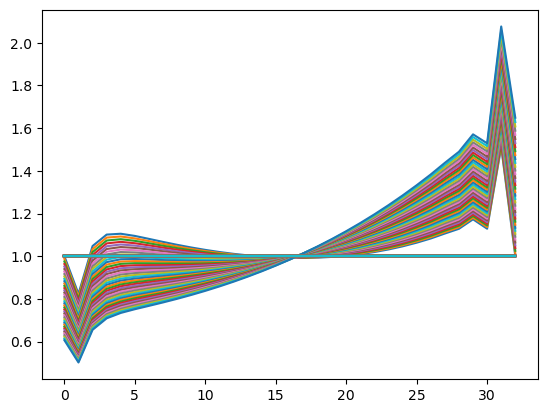

In [52]:
for i in range(len(P)):
    plt.plot(P[i])

Note: this plot is the set of all solutions for all the time steps in the discretization. The horizontal lines $P=1$ should not be considered, they are just the ones that are left from the initialization of the $P$ vector.

Now, as an example, we compare the analytical solution at the boundary $\left( \tau=1, \hat{B_i}=1, \hat{G_J}=1  \right)$ with the numerical solution. They are equal, so the boundary condition is well implemented. I did this for the other boundary, and it is okay too.

In [56]:
analytical_solution(B_mesh[space_steps], G_mesh[space_steps],1) == P[time_steps][-1]

True

Now we compare the graph of both the analytical and numerical solutions fixing $\hat{B}=1$ and $\tau=1$.

Text(0.5, 1.0, 'Comparação com $B$ fixo, $t=0$')

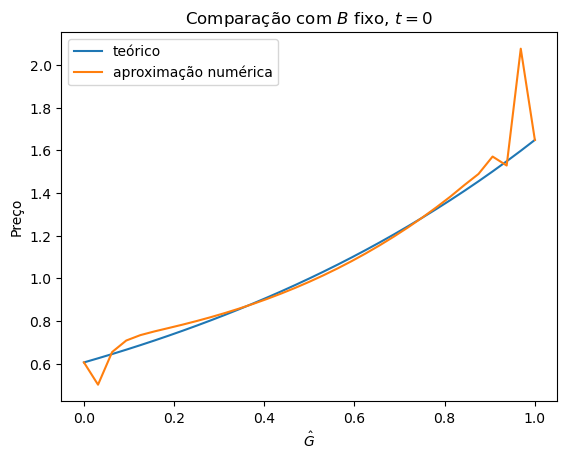

In [62]:
sol = []
for i in range(space_steps+1):
    sol.append(analytical_solution(B_mesh[space_steps],G_mesh[i], 1))
plt.plot(G_mesh,sol,label="teórico")
plt.plot(G_mesh,P[time_steps],label="aproximação numérica")
plt.legend()
plt.ylabel("Preço")
plt.xlabel("$\hat{G}$")
plt.title("Comparação com $B$ fixo, $t=0$")

Same thing but with $\hat{B}=1$ and $\tau=0.5$.

Text(0.5, 1.0, 'Comparação com $B$ fixo, $t=0.5$')

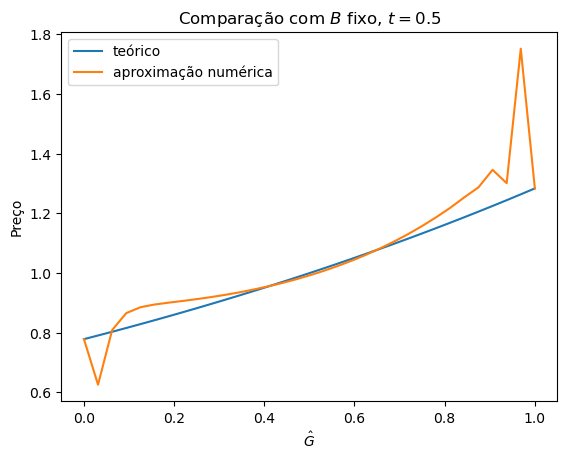

In [63]:
sol = []
for i in range(space_steps+1):
    sol.append(analytical_solution(B_mesh[space_steps],G_mesh[i], 0.5))
plt.plot(G_mesh,sol,label="teórico")
plt.plot(G_mesh,P[20],label="aproximação numérica")
plt.legend()
plt.ylabel("Preço")
plt.xlabel("$\hat{G}$")
plt.title("Comparação com $B$ fixo, $t=0.5$")

Same thing but with $\hat{B}=1$ and $\tau=0.025$.

Text(0.5, 1.0, 'Comparação com $B$ fixo, $t=0.975$')

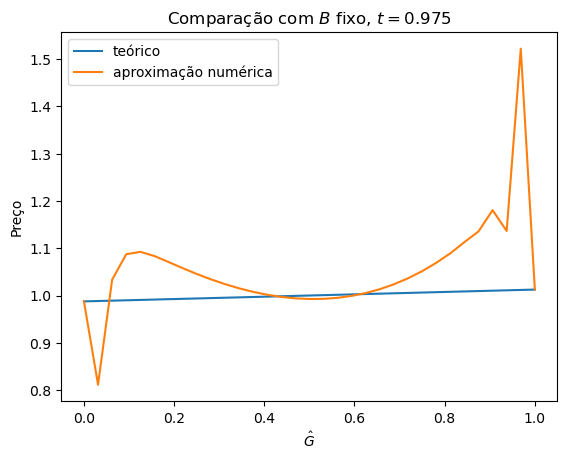

In [72]:
sol = []
for i in range(space_steps+1):
    sol.append(analytical_solution(B_mesh[space_steps],G_mesh[i], 0.025))
plt.plot(G_mesh,sol,label="teórico")
plt.plot(G_mesh,P[1],label="aproximação numérica")
plt.legend()
plt.ylabel("Preço")
plt.xlabel("$\hat{G}$")
plt.title("Comparação com $B$ fixo, $t=0.975$")

In this last one we can clearly see the difference between the analytical and numerical solutions. So, something must be wrong with the code.